In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sqlalchemy import create_engine
import os
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

le = pd.read_sql_query('select * from lifeexpectancy', con=engine)

engine.dispose()

In [2]:
le.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


We've loaded the dataset into a dataframe, lf, so now we need to start cleaning the data, making sure we can use the data properly.

# Data Cleaning

For each of the columns we have in our data, we need to determine what kind of variables we are dealing with, what exactly is wrong or missing from them, and what outliers we have in our dataset.

First thing we notice is that each of our columns have some extra spaces and such, so we can clean them up a bit.

In [3]:
old_cols = list(le.columns)
new_cols = []
for col in old_cols:
    new_cols.append(col.strip().replace('  ', ' ').replace(' ', '_').lower())
le.columns = new_cols
le.head()

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,...,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_1-19_years,thinness_5-9_years,income_composition_of_resources,schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [4]:
le.columns

Index(['country', 'year', 'status', 'life_expectancy', 'adult_mortality',
       'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b',
       'measles', 'bmi', 'under-five_deaths', 'polio', 'total_expenditure',
       'diphtheria', 'hiv/aids', 'gdp', 'population', 'thinness_1-19_years',
       'thinness_5-9_years', 'income_composition_of_resources', 'schooling'],
      dtype='object')

Variable Descriptions

Format: variable (type) - description

country (Nominal) - the country in which the indicators are from (i.e. United States of America or Congo)

year (Ordinal) - the calendar year the indicators are from (ranging from 2000 to 2015)

status (Nominal) - whether a country is considered to be 'Developing' or 'Developed' by WHO standards

life_expectancy (Ratio) - the life expectancy of people in years for a particular country and year

adult_mortality (Ratio) - the adult mortality rate per 1000 population (i.e. number of people dying between 15 and 60 years per 1000 population); if the rate is 263 then that means 263 people will die out of 1000 between the ages of 15 and 60; another way to think of this is that the chance an individual will die between 15 and 60 is 26.3%

infant_deaths (Ratio) - number of infant deaths per 1000 population; similar to above, but for infants

alcohol (Ratio) - a country's alcohol consumption rate measured as liters of pure alcohol consumption per capita

percentage_expenditure (Ratio) - expenditure on health as a percentage of Gross Domestic Product (gdp)

hepatitis_b (Ratio) - number of 1 year olds with Hepatitis B immunization over all 1 year olds in population

measles (Ratio) - number of reported Measles cases per 1000 population

bmi (Interval/Ordinal) - average Body Mass Index (BMI) of a country's total population

under-five_deaths (Ratio) - number of people under the age of five deaths per 1000 population

polio (Ratio) - number of 1 year olds with Polio immunization over the number of all 1 year olds in population

total_expenditure (Ratio) - government expenditure on health as a percentage of total government expenditure

diphtheria (Ratio) - Diphtheria tetanus toxoid and pertussis (DTP3) immunization rate of 1 year olds

hiv/aids (Ratio) - deaths per 1000 live births caused by HIV/AIDS for people under 5; number of people under 5 who die due to HIV/AIDS per 1000 births

gdp (Ratio) - Gross Domestic Product per capita

population (Ratio) - population of a country

thinness_1-19_years (Ratio) - rate of thinness among people aged 10-19 (Note: variable should be renamed to thinness_10-19_years to more accurately represent the variable)

thinness_5-9_years (Ratio) - rate of thinness among people aged 5-9

income_composition_of_resources (Ratio) - Human Development Index in terms of income composition of resources (index ranging from 0 to 1)

schooling (Ratio) - average number of years of schooling of a population

As stated by our variable descriptions, we should change the name of the thinness_1-19_years variable to thinness_10-19_years to represent what the column actually has.

In [5]:
le.rename(columns={'thinness_1-19_years':'thinness_10-19_years'}, inplace=True)

So now that we have cleaned up our column names and such, we can move on to filling in data that we need to either replace or remove, or even add in if it's missing. For that we can use a few different methods.

In [6]:
le.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
country                            2938 non-null object
year                               2938 non-null int64
status                             2938 non-null object
life_expectancy                    2928 non-null float64
adult_mortality                    2928 non-null float64
infant_deaths                      2938 non-null int64
alcohol                            2744 non-null float64
percentage_expenditure             2938 non-null float64
hepatitis_b                        2385 non-null float64
measles                            2938 non-null int64
bmi                                2904 non-null float64
under-five_deaths                  2938 non-null int64
polio                              2919 non-null float64
total_expenditure                  2712 non-null float64
diphtheria                         2919 non-null float64
hiv/aids                           2938 non-null

In [7]:
le.describe()

,year,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_10-19_years,thinness_5-9_years,income_composition_of_resources,schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


So in terms of dtypes, all of our variables seem to be proper objects, integers, and floats, but taking a look at the describe() function, we do run into some problems. 

Adult mortality rates minimum is at 1, so there is an error we must address there.

Infant death miniumum at 0 at lowest and 1800 at highest, both not exactly plausible.

Minimum BMI at 1 and maximum BMI at 87 are likely errors, as the average range falls between 15 to 40, where 15 is already severely underweight and 40 is extremely obese.

Under five deaths is extremely unlikely to have at 0 as well.

GDP per capita minimum at $1.68 is quite low and likely not possible, but perhaps in an extremely impoverished area.

Minimum population of 34 in a country just isn't feasible.

##### The easiest way we can see these outliers will have to be in graph form. For this type, we want to use a boxplot to see roughly where our outliers lie

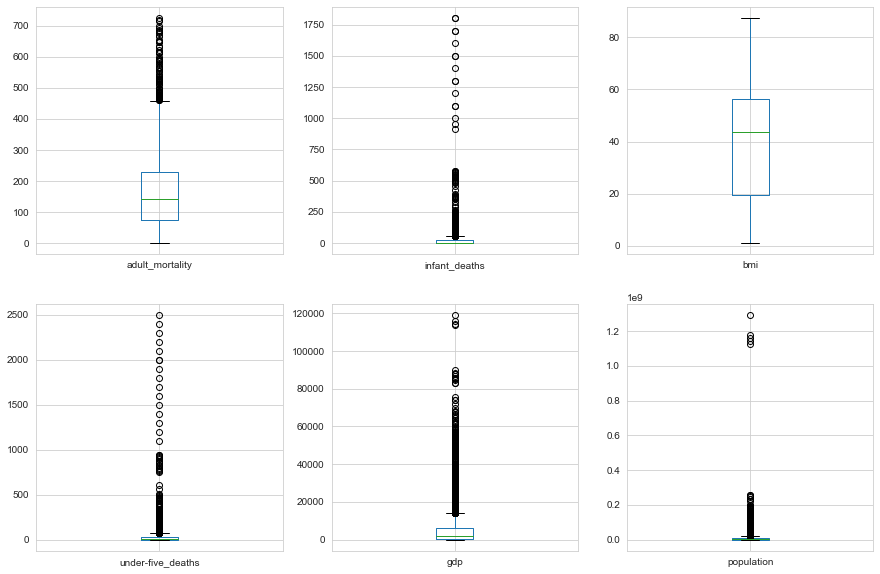

In [8]:
plt.figure(figsize=(15,10))
for i, col in enumerate(['adult_mortality', 'infant_deaths', 'bmi', 'under-five_deaths', 'gdp', 'population'], start=1):
    plt.subplot(2, 3, i)
    le.boxplot(col)

Some of our values may simply just be outliers, but there are a lot of them that must be errors in calculation of some sort. So what we should do is drop all the values that don't make any sense in actual calculation or on paper. We can replace all our erroneous values with np.nan to still be able to calculate the columns properly.

In [9]:
mort_5_perc = np.percentile(le.adult_mortality.dropna(), 5)
le.adult_mortality = le.apply(lambda x: np.nan if x.adult_mortality < mort_5_perc else x.adult_mortality, axis = 1)
le.infant_deaths = le.infant_deaths.replace(0, np.nan)
le.bmi = le.apply(lambda x: np.nan if (x.bmi < 10 or x.bmi > 50) else x.bmi, axis=1)
le['under-five_deaths'] = le['under-five_deaths'].replace(0, np.nan)

In [10]:
le.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
country                            2938 non-null object
year                               2938 non-null int64
status                             2938 non-null object
life_expectancy                    2928 non-null float64
adult_mortality                    2783 non-null float64
infant_deaths                      2090 non-null float64
alcohol                            2744 non-null float64
percentage_expenditure             2938 non-null float64
hepatitis_b                        2385 non-null float64
measles                            2938 non-null int64
bmi                                1482 non-null float64
under-five_deaths                  2153 non-null float64
polio                              2919 non-null float64
total_expenditure                  2712 non-null float64
diphtheria                         2919 non-null float64
hiv/aids                           2938 non-

In [11]:
def nulls_breakdown(df=le):    
    df_cols = list(df.columns)
    cols_total_count = len(list(df.columns))
    cols_count = 0
    for loc, col in enumerate(df_cols):
        null_count = df[col].isnull().sum()
        total_count = df[col].isnull().count()
        percent_null = round(null_count/total_count*100, 2)
        if null_count > 0:
            cols_count += 1
            print('{} has {} null values: {}% null'.format(col, null_count, percent_null))
    cols_percent_null = round(cols_count/cols_total_count*100, 2)
    print('Out of {} total columns, {} contain null values; {}% columns contain null values.'.format(cols_total_count, cols_count, cols_percent_null))

In [12]:
nulls_breakdown()

life_expectancy has 10 null values: 0.34% null
adult_mortality has 155 null values: 5.28% null
infant_deaths has 848 null values: 28.86% null
alcohol has 194 null values: 6.6% null
hepatitis_b has 553 null values: 18.82% null
bmi has 1456 null values: 49.56% null
under-five_deaths has 785 null values: 26.72% null
polio has 19 null values: 0.65% null
total_expenditure has 226 null values: 7.69% null
diphtheria has 19 null values: 0.65% null
gdp has 448 null values: 15.25% null
population has 652 null values: 22.19% null
thinness_10-19_years has 34 null values: 1.16% null
thinness_5-9_years has 34 null values: 1.16% null
income_composition_of_resources has 167 null values: 5.68% null
schooling has 163 null values: 5.55% null
Out of 22 total columns, 16 contain null values; 72.73% columns contain null values.


The BMI category is almost half null, so it's probably best to remove this entire category

In [13]:
le.drop(columns='bmi', inplace=True)

So let's interpolate the data we have here to fill in any missing data we have. At first, using the interpolate function, we ended up with 1 lone null value, but using the mean, we end up with no null values whatsoever.

    adult_mortality has 1 null values: 0.03% null
    Out of 21 total columns, 1 contain null values; 4.76% columns contain null values.

In [14]:
imputed_data = []
for year in list(le.year.unique()):
    year_data = le[le.year == year].copy()
    for col in list(year_data.columns)[3:]:
        year_data[col] = year_data[col].fillna(year_data[col].dropna().mean()).copy()
    imputed_data.append(year_data)
le = pd.concat(imputed_data).copy()

In [15]:
le.head()

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,...,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_10-19_years,thinness_5-9_years,income_composition_of_resources,schooling
0,Afghanistan,2015,Developing,65.0,263.0,62.000000,0.010000,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,3.373649e+07,17.2,17.3,0.479,10.1
16,Albania,2015,Developing,77.8,74.0,35.129032,4.600000,364.975229,99.0,0,...,99.0,6.00,99.0,0.1,3954.227830,2.887300e+04,1.2,1.3,0.762,14.2
32,Algeria,2015,Developing,75.6,19.0,21.000000,5.288333,0.000000,95.0,63,...,95.0,7.08,95.0,0.1,4132.762920,3.987153e+07,6.0,5.8,0.743,14.4
49,Angola,2015,Developing,52.4,335.0,66.000000,5.288333,0.000000,64.0,118,...,7.0,7.08,64.0,1.9,3695.793748,2.785935e+06,8.3,8.2,0.531,11.4
65,Antigua and Barbuda,2015,Developing,76.4,13.0,35.129032,5.288333,0.000000,99.0,0,...,86.0,7.08,99.0,0.2,13566.954100,1.109741e+07,3.3,3.3,0.784,13.9


In [16]:
nulls_breakdown(le)

Out of 21 total columns, 0 contain null values; 0.0% columns contain null values.


Following that, we need to find our outliers and see if they exist, which they most likely do in our dataset, as we have already seen them. But here we can more visually understand what it looks like using both histogram and boxplots.

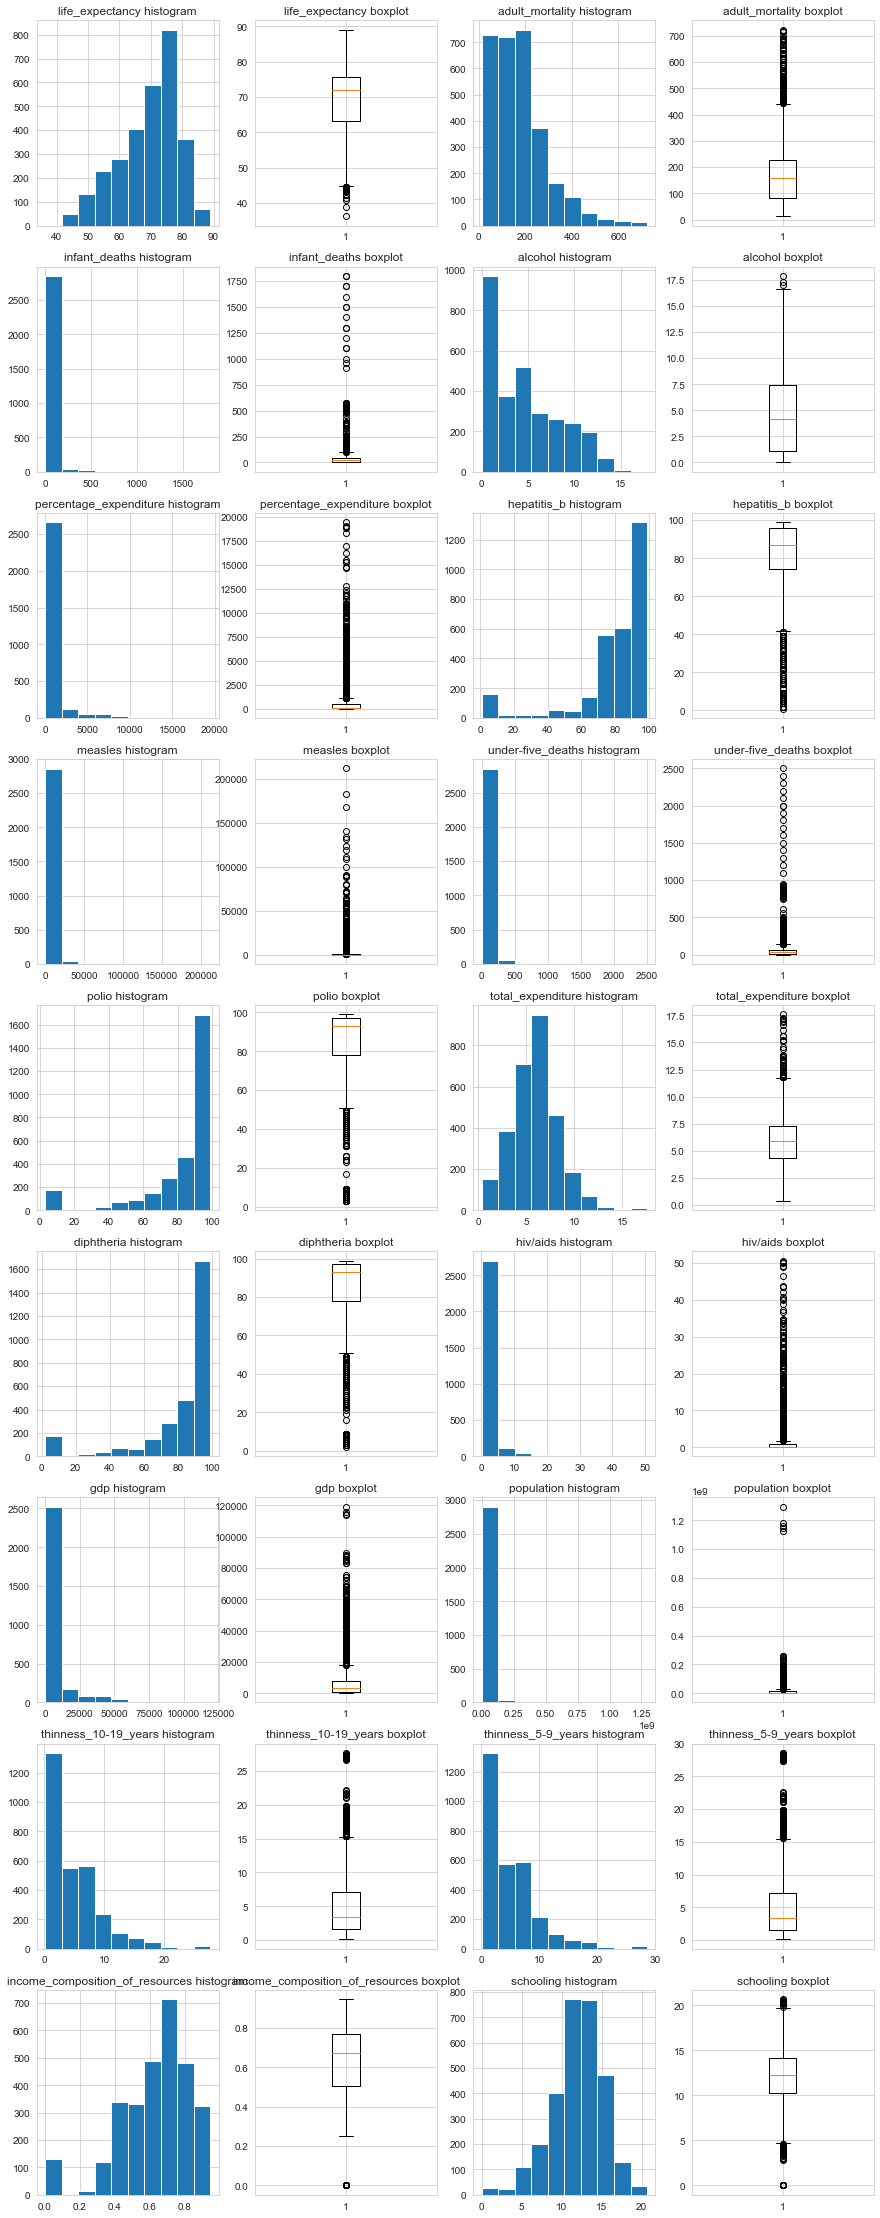

In [17]:
variables = list(le.columns)[3:]
def outliers(data):
    plt.figure(figsize=(15,40))
    i=0
    for col in variables:
        i += 1
        plt.subplot(9,4,i)
        plt.hist(data[col])
        plt.title('{} histogram'.format(col))
        i+= 1
        plt.subplot(9,4,i)
        plt.boxplot(data[col])
        plt.title('{} boxplot'.format(col))
    plt.show()
outliers(le)

There are so many outliers in our data. The data we are supposed to focus on is what factors affect life expectancy. The life expectancy variable istelf has quite a few outliers in it. Personally I prefer Tukey's method by limiting our IQR. I want to stick to what our life expectancy variable looks like, so we can winsorize the lower outliers off our data. These will all be adjusted by trial and error with visual analysis.

In [18]:
from scipy.stats.mstats import winsorize
def test_wins(col, lower_limit=0, upper_limit=0, show_plot=True):
    wins_data = winsorize(le[col], limits=(lower_limit, upper_limit))
    wins_dict[col] = wins_data
    if show_plot == True:
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.boxplot(le[col])
        plt.title('original {}'.format(col))
        plt.subplot(122)
        plt.boxplot(wins_data)
        plt.title('wins=({},{}) {}'.format(lower_limit, upper_limit, col))
        plt.show()

In [19]:
wins_dict = {}

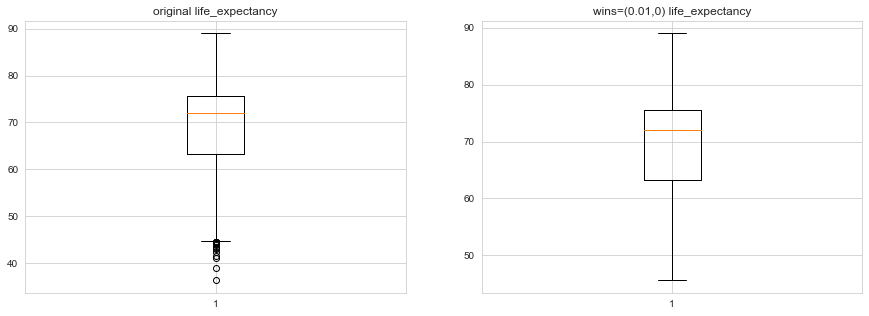

In [20]:
test_wins(variables[0], lower_limit = 0.01, show_plot=True)
#limiting the lower 1% only gives us no outliers

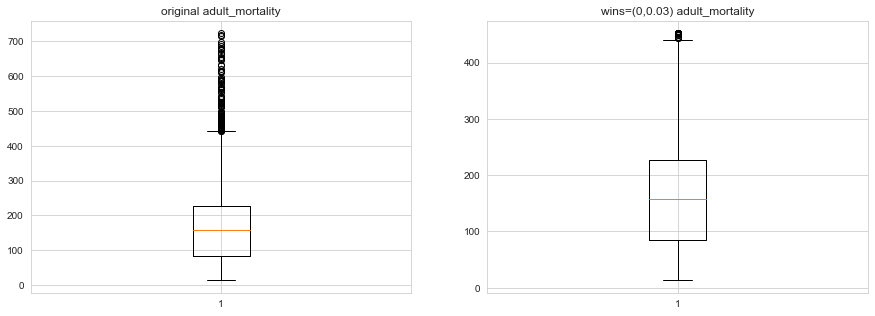

In [21]:
test_wins(variables[1], lower_limit = 0, upper_limit = .03, show_plot=True)

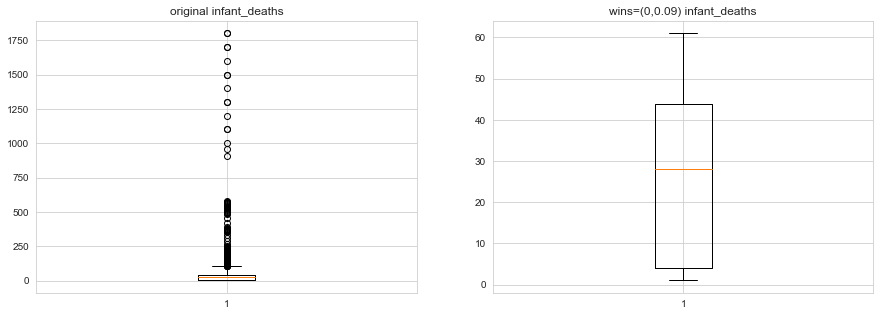

In [22]:
test_wins(variables[2], lower_limit = 0, upper_limit = .09, show_plot=True)

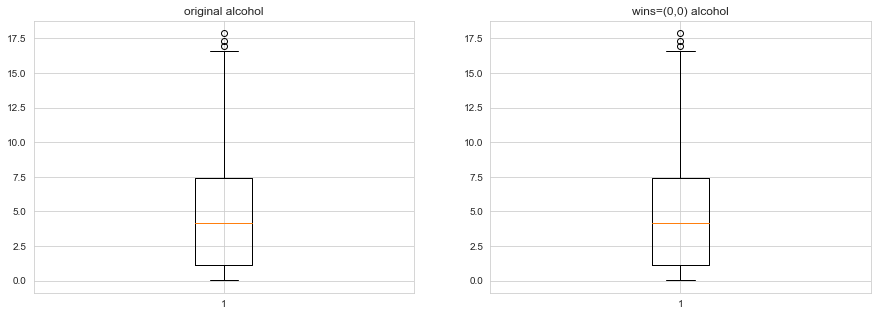

In [23]:
test_wins(variables[3], lower_limit = 0, upper_limit = 0, show_plot=True)
#No adjustmest necessary

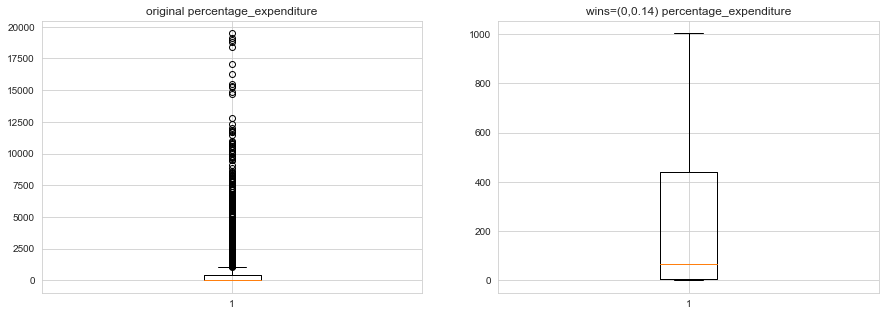

In [24]:
test_wins(variables[4], lower_limit = 0, upper_limit = 0.14, show_plot=True)

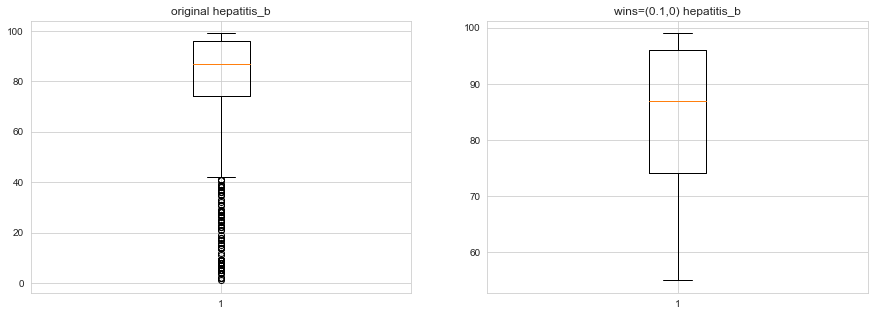

In [25]:
test_wins(variables[5], lower_limit = 0.1, upper_limit = 0, show_plot=True)

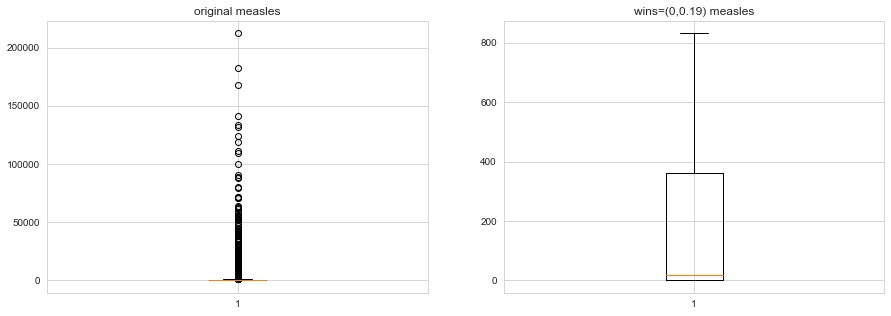

In [26]:
test_wins(variables[6], lower_limit = 0, upper_limit = 0.19, show_plot=True)

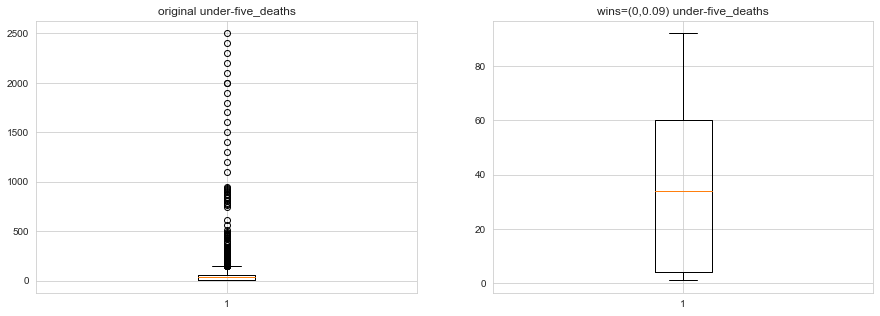

In [27]:
test_wins(variables[7], lower_limit = 0, upper_limit = 0.09, show_plot=True)

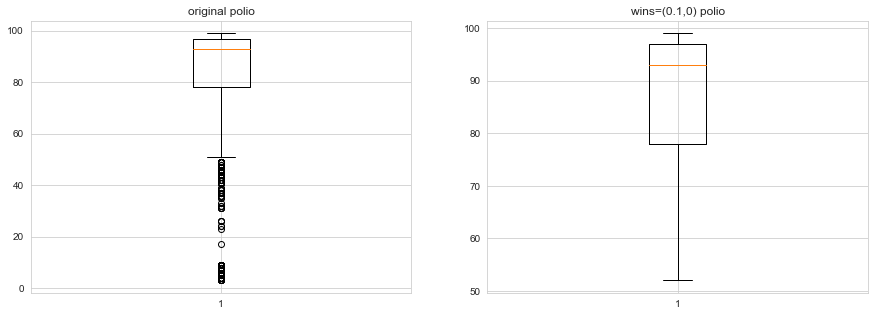

In [28]:
test_wins(variables[8], lower_limit = 0.1, upper_limit = 0, show_plot=True)

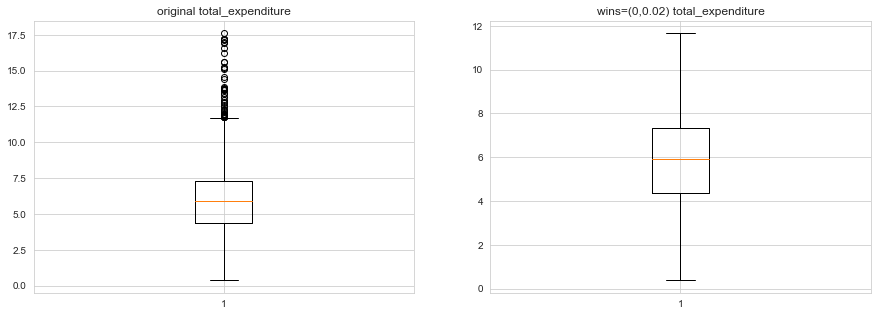

In [29]:
test_wins(variables[9], lower_limit = 0, upper_limit = 0.02, show_plot=True)

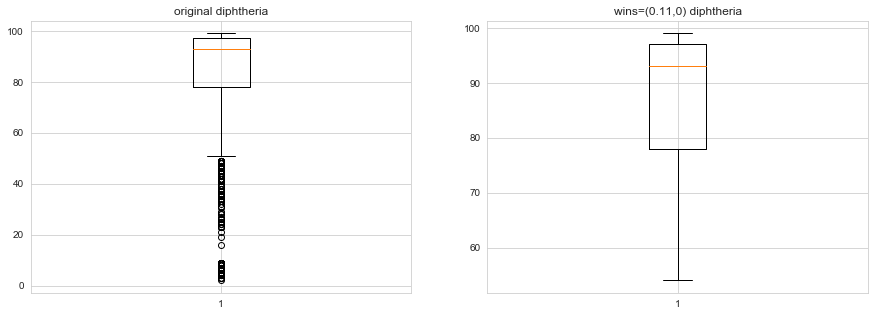

In [30]:
test_wins(variables[10], lower_limit = 0.11, upper_limit = 0, show_plot=True)

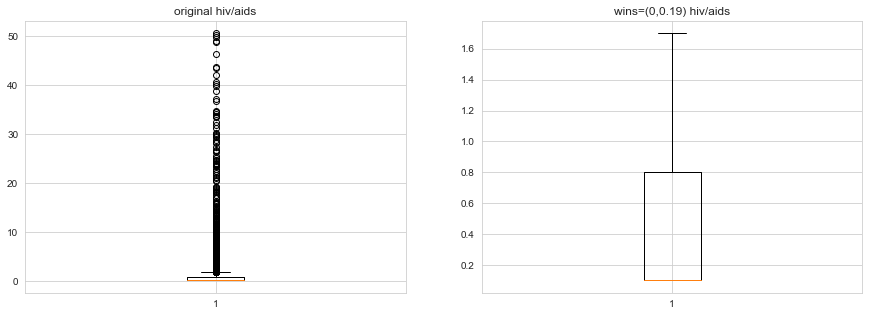

In [31]:
test_wins(variables[11], lower_limit = 0, upper_limit = 0.19, show_plot=True)

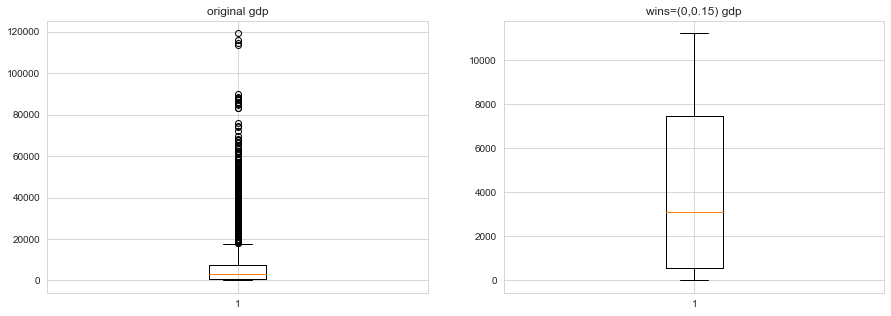

In [32]:
test_wins(variables[12], lower_limit = 0, upper_limit = 0.15, show_plot=True)

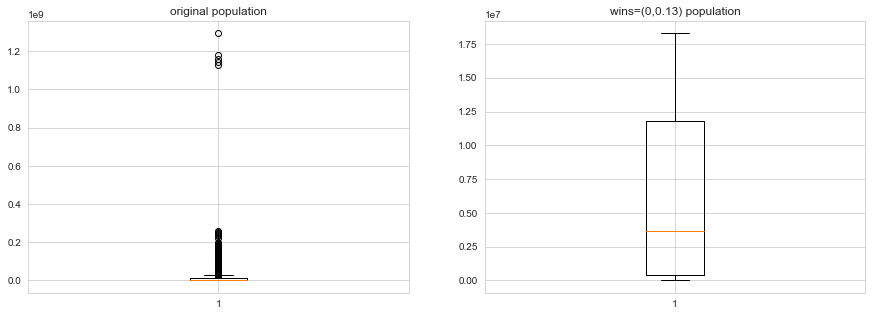

In [33]:
test_wins(variables[13], lower_limit = 0, upper_limit = 0.13, show_plot=True)

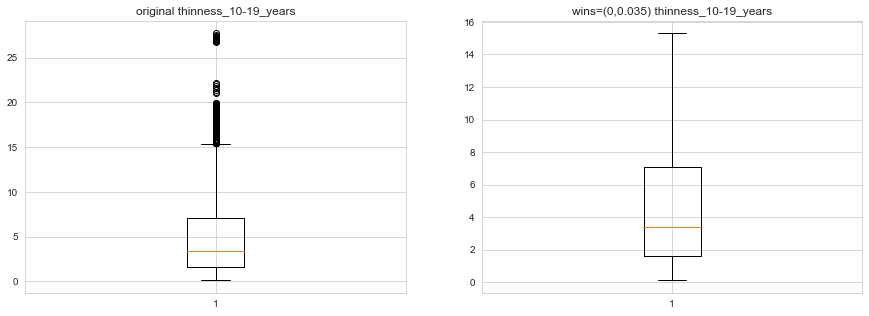

In [34]:
test_wins(variables[14], lower_limit = 0, upper_limit = 0.035, show_plot=True)

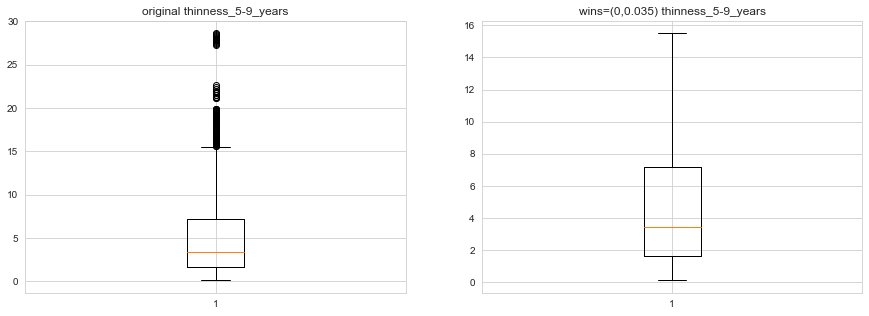

In [35]:
test_wins(variables[15], lower_limit = 0, upper_limit = 0.035, show_plot=True)

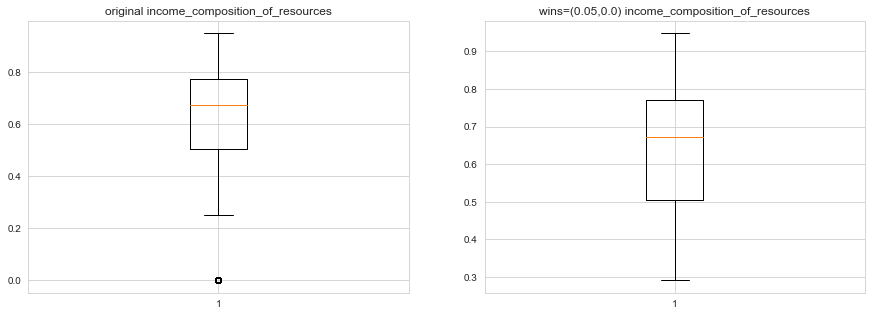

In [36]:
test_wins(variables[16], lower_limit = 0.05, upper_limit = 0., show_plot=True)

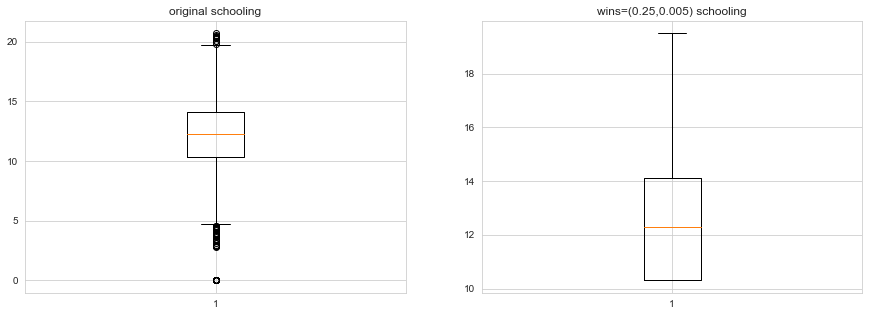

In [37]:
test_wins(variables[17], lower_limit = 0.25, upper_limit = 0.005, show_plot=True)

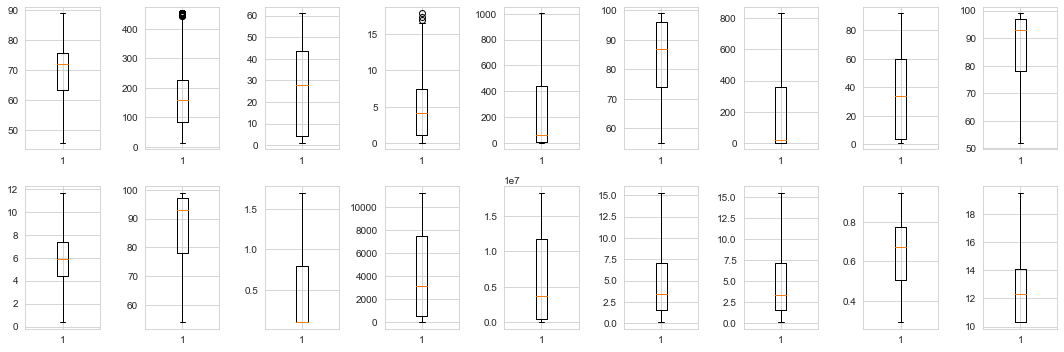

In [38]:
plt.figure(figsize=(15,5))
for i, col in enumerate(variables, 1):
    plt.subplot(2, 9, i)
    plt.boxplot(wins_dict[col])
plt.tight_layout()
plt.show()

In [39]:
wins_df = le.iloc[:, 0:3]
for col in variables:
    wins_df[col] = wins_dict[col]

So now we have created a brand new dataframe with our winsorized values factored in, so we can now begin the analysis and exploration portion. To get an idea of what our data looks like, we should describe() it once again.

In [40]:
wins_df.describe()

,year,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_10-19_years,thinness_5-9_years,income_composition_of_resources,schooling
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,2938.000000,2938.000000,2938.000000
mean,2007.518720,69.248795,170.019723,26.388807,4.644013,271.234472,83.671293,220.691287,35.636461,85.514684,5.972192,85.683315,0.508237,4335.523332,6.595678e+06,4.703351,4.720470,0.640659,12.642386
std,4.613841,9.462136,109.703681,21.052713,3.919849,363.172291,13.848933,329.192321,31.128439,15.270927,2.302224,14.752870,0.640847,4056.717717,6.754515e+06,3.925702,3.964268,0.171622,2.223122
min,2000.000000,45.600000,13.000000,1.000000,0.010000,0.000000,55.000000,0.000000,1.000000,52.000000,0.370000,54.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.291000,10.300000
25%,2004.000000,63.200000,84.000000,4.000000,1.092500,4.685343,74.099237,0.000000,4.000000,78.000000,4.370000,78.000000,0.100000,580.486996,4.189172e+05,1.600000,1.600000,0.504250,10.300000
50%,2008.000000,72.000000,157.000000,28.000000,4.140000,64.912906,87.000000,17.000000,34.000000,93.000000,5.910000,93.000000,0.100000,3116.561755,3.675929e+06,3.400000,3.400000,0.673000,12.300000
75%,2012.000000,75.600000,227.000000,43.766917,7.390000,441.534144,96.000000,360.250000,60.014815,97.000000,7.330000,97.000000,0.800000,7464.487887,1.181332e+07,7.100000,7.200000,0.772000,14.100000
max,2015.000000,89.000000,452.000000,61.000000,17.870000,1002.833273,99.000000,831.000000,92.000000,99.000000,11.660000,99.000000,1.700000,11224.154800,1.828185e+07,15.300000,15.500000,0.948000,19.500000


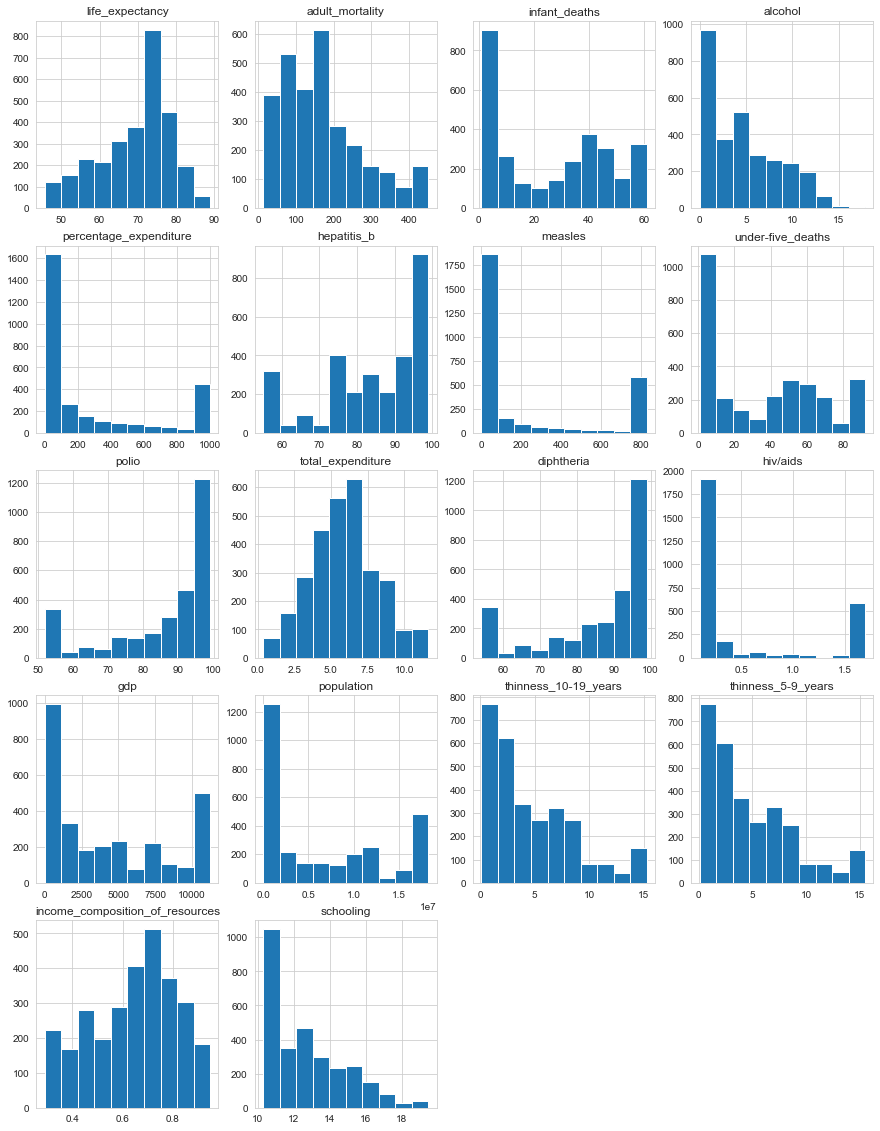

In [41]:
plt.figure(figsize=(15, 20))
for i, col in enumerate(variables, 1):
    plt.subplot(5, 4, i)
    plt.hist(wins_df[col])
    plt.title(col)

In [42]:
wins_df[variables].corr()

,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_10-19_years,thinness_5-9_years,income_composition_of_resources,schooling
life_expectancy,1.000000,-0.680700,-0.176719,0.394427,0.488499,0.315120,-0.337887,-0.268480,0.573291,0.222306,0.582534,-0.797204,0.488145,0.011077,-0.514966,-0.512694,0.792878,0.711560
adult_mortality,-0.680700,1.000000,0.092890,-0.185329,-0.290473,-0.214312,0.214998,0.153813,-0.346427,-0.117300,-0.351977,0.599005,-0.280184,0.003933,0.332684,0.339064,-0.509303,-0.438394
infant_deaths,-0.176719,0.092890,1.000000,-0.030336,-0.053502,-0.161760,0.230654,0.954117,-0.171229,-0.042918,-0.182256,0.091471,-0.022209,0.125335,0.142056,0.153494,-0.144183,-0.101265
alcohol,0.394427,-0.185329,-0.030336,1.000000,0.375369,0.106828,-0.197229,-0.083889,0.265754,0.307438,0.276968,-0.197247,0.383501,-0.038965,-0.436245,-0.426656,0.474789,0.545883
percentage_expenditure,0.488499,-0.290473,-0.053502,0.375369,1.000000,0.126123,-0.197055,-0.103775,0.269704,0.158815,0.273940,-0.299011,0.636476,-0.095251,-0.332210,-0.334047,0.555798,0.581774
hepatitis_b,0.315120,-0.214312,-0.161760,0.106828,0.126123,1.000000,-0.266487,-0.217267,0.608008,0.071100,0.651941,-0.279915,0.199104,0.023994,-0.134103,-0.139528,0.299493,0.249263
measles,-0.337887,0.214998,0.230654,-0.197229,-0.197055,-0.266487,1.000000,0.292205,-0.320104,-0.161737,-0.317720,0.226950,-0.197419,0.186050,0.359571,0.364201,-0.274976,-0.290924
under-five_deaths,-0.268480,0.153813,0.954117,-0.083889,-0.103775,-0.217267,0.292205,1.000000,-0.247146,-0.060030,-0.259827,0.175311,-0.080398,0.139403,0.193548,0.201032,-0.233380,-0.173361
polio,0.573291,-0.346427,-0.171229,0.265754,0.269704,0.608008,-0.320104,-0.247146,1.000000,0.164149,0.859133,-0.476682,0.318115,0.018491,-0.288660,-0.287206,0.515361,0.445088
total_expenditure,0.222306,-0.117300,-0.042918,0.307438,0.158815,0.071100,-0.161737,-0.060030,0.164149,1.000000,0.177267,-0.110717,0.147805,-0.108427,-0.285700,-0.294560,0.185535,0.278720


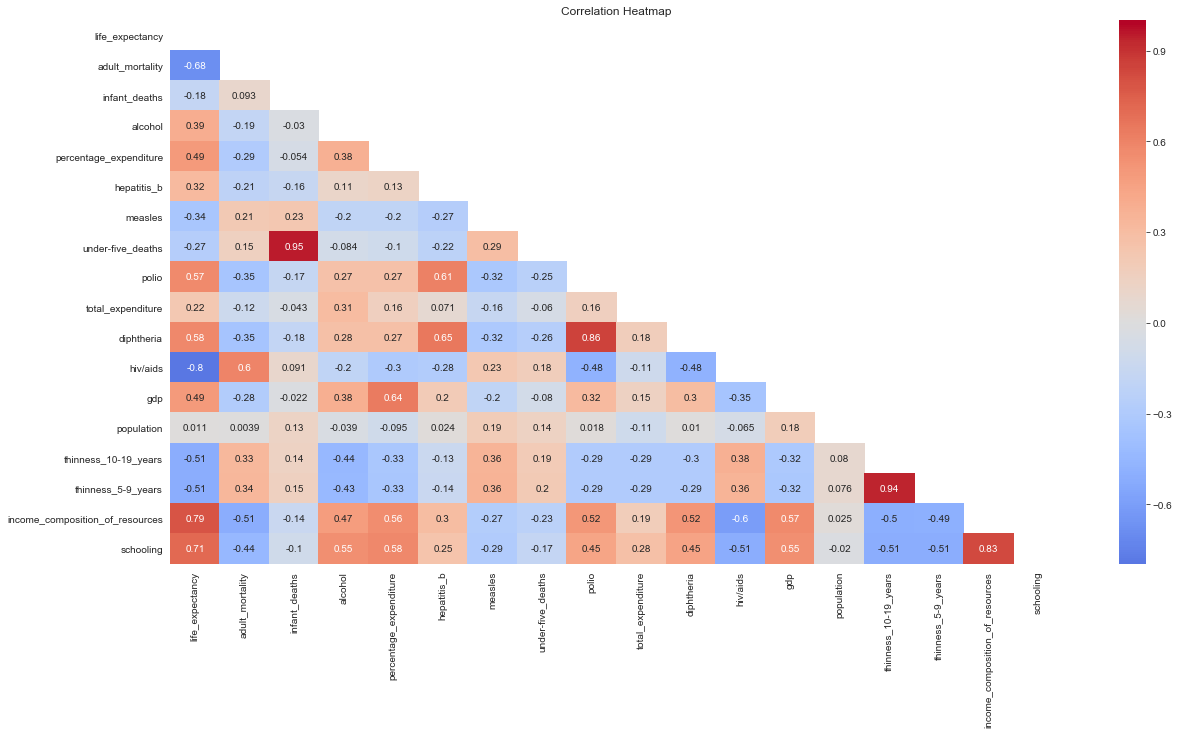

In [43]:
mask = np.triu(wins_df[variables].corr())
plt.figure(figsize = (20,10))
sns.heatmap(wins_df[variables].corr(), cmap='coolwarm', annot=True, center=0, fmt='.2g',mask=mask)
plt.ylim(18,0)
plt.title('Correlation Heatmap')
plt.show()

The heatmap above shows a lot of information. The darker blues represent higher negative correlation, and the darker reds represent higher positive correlation. Most notably we have:

Life expectancy correlating highly with Adult Mortality(-), HIV/AIDS(-), Income Composition of Resources(+), Schooling(+)

Life expectancy not correlated whatsoever with population.

Infant deaths and Under Five deaths are highly correlated (which makes sense of course).

Diphtheria and Polio vaccinations very highly correlated (which also makes sense, because if you're getting vaccinated for one, why not get the other, and all other vaccines as well). 

Percent Expenditure and GDP are highly correlated which also makes sense.

HIV/AIDS and Income Composition of Resources are relatively negatively correlated.

Thinness of 5-9 year olds and Thinness of 10-15 year olds is extremely correlated, so those who remain thin stay thin, and those who are overweight stay overweight.

Income and Schooling are highly correlated.

In [44]:
wins_df.year.corr(wins_df.life_expectancy)

0.1697964496445902

So the comparison of each year to life expectancy does have some correlation. So we can take a t-test for each year to see the significance of each year.

In [45]:
years = list(wins_df.year.unique())
years.sort()

In [46]:
yearly_le = {}
for year in years:
    year_data = wins_df[wins_df.year == year].life_expectancy
    yearly_le[year] = year_data

In [47]:
import scipy.stats as stats
for year in years[:-1]:
    print(str(year)+' to '+str(year+1))
    print(stats.ttest_ind(yearly_le[year], yearly_le[year+1], equal_var=False))

2000 to 2001
Ttest_indResult(statistic=-0.339874273786677, pvalue=0.734147249286317)
2001 to 2002
Ttest_indResult(statistic=-0.18288775743069652, pvalue=0.8549879128960569)
2002 to 2003
Ttest_indResult(statistic=-0.09788073999943862, pvalue=0.922080868750695)
2003 to 2004
Ttest_indResult(statistic=-0.20076791323205204, pvalue=0.8409921852108724)
2004 to 2005
Ttest_indResult(statistic=-0.5360239830703207, pvalue=0.5922696887371386)
2005 to 2006
Ttest_indResult(statistic=-0.43512464639644277, pvalue=0.6637298353979988)
2006 to 2007
Ttest_indResult(statistic=-0.35499521065847695, pvalue=0.7227988446996725)
2007 to 2008
Ttest_indResult(statistic=-0.39657900568183463, pvalue=0.6919107746155075)
2008 to 2009
Ttest_indResult(statistic=-0.5367008466564068, pvalue=0.5918023223783456)
2009 to 2010
Ttest_indResult(statistic=-0.1700909700517618, pvalue=0.8650331171162933)
2010 to 2011
Ttest_indResult(statistic=-0.587282689417737, pvalue=0.5573781741392467)
2011 to 2012
Ttest_indResult(statistic=-0

According to our t-tests, there is no significant difference from year to year for this data and it very likely occurred by chance. Therefore the year variable would not be significant to us in this analysis.

So we must try another variable to see if there is any correlation. One variable that stands out also was the Status of the country, whether they be Developing or Developed. Because it's binary, it would be easy to work with, so we can use this to our advantage to see if there is significance in the difference of these groups.

In [48]:
wins_df.groupby('status').life_expectancy.mean()

status
Developed     79.197852
Developing    67.149077
Name: life_expectancy, dtype: float64

So a developed country has a much higher life expectancy than that of a developing country. From here we can develop an analysis it seems, but first we have to take a t-test to see if this variance is significant to us.

In [49]:
developed = wins_df[wins_df.status == "Developed"].life_expectancy
developing = wins_df[wins_df.status == 'Developing'].life_expectancy
stats.ttest_ind(developed, developing, equal_var = False)

Ttest_indResult(statistic=47.96440581661328, pvalue=2e-323)

So according to our test here, the significance is quite large between the two types of countries. So now we can use these two statuses and aggregate a proper amount of data to come up with some descriptive statitics before we engineer some features to the data.

In [50]:
wins_df_cols = list(wins_df.columns)
status_var = [wins_df_cols[2]]

In [51]:
for col in wins_df_cols[4:]:
    status_var.append(col)

In [52]:
wins_df[status_var].groupby('status').mean()

,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_10-19_years,thinness_5-9_years,income_composition_of_resources,schooling
status,,,,,,,,,,,,,,,,,
Developed,96.516154,27.956075,9.578542,599.246259,86.930131,127.019531,34.917279,94.324219,7.399336,94.355469,0.100000,7782.280329,5.721908e+06,1.320703,1.29668,0.831395,15.462831
Developing,185.532430,26.058040,3.602596,202.008571,82.983525,240.460429,35.788242,83.655458,5.670997,83.853083,0.594394,3608.095640,6.780085e+06,5.417248,5.44305,0.600405,12.047140


In [53]:
developed_df = wins_df[wins_df.status == 'Developed']
developing_df = wins_df[wins_df.status == 'Developing']
for col in status_var[1:]:
    print(5*'-' + str(col) + ' Developed/Developing t-test comparison' + 5*'-')
    print(str(stats.ttest_ind(developed_df[col], developing_df[col], equal_var=False)[:]))

-----adult_mortality Developed/Developing t-test comparison-----
(-28.270115004616137, 5.643176028868728e-146)
-----infant_deaths Developed/Developing t-test comparison-----
(1.9784529173978271, 0.04822160045409596)
-----alcohol Developed/Developing t-test comparison-----
(41.64640462462027, 9.363838648443535e-204)
-----percentage_expenditure Developed/Developing t-test comparison-----
(19.75129348851994, 9.086022962551167e-68)
-----hepatitis_b Developed/Developing t-test comparison-----
(7.085304639458481, 2.723238539034132e-12)
-----measles Developed/Developing t-test comparison-----
(-8.88568417780416, 2.9382584495687677e-18)
-----under-five_deaths Developed/Developing t-test comparison-----
(-0.6389116231336913, 0.5230550872404477)
-----polio Developed/Developing t-test comparison-----
(24.765028104309675, 3.17392644067064e-118)
-----total_expenditure Developed/Developing t-test comparison-----
(14.102447171314608, 1.1202855294470609e-39)
-----diphtheria Developed/Developing t-test

Almost every single one of these variables has some kind of correlation to whether it is in a Developed or Developing country. Which also implies it has some correlation to Life Expectancy as well. So we can use this variable in our feature engineering section.

# Feature Engineering

In [54]:
feat_df = wins_df.join(pd.get_dummies(wins_df.status)).drop(columns = 'status').copy()
feat_df.head()

,country,year,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,under-five_deaths,...,diphtheria,hiv/aids,gdp,population,thinness_10-19_years,thinness_5-9_years,income_composition_of_resources,schooling,Developed,Developing
0,Afghanistan,2015,65.0,263.0,61.000000,0.010000,71.279624,65.0,831,83.000000,...,65.0,0.1,584.259210,1.828185e+07,15.3,15.5,0.479,10.3,0,1
16,Albania,2015,77.8,74.0,35.129032,4.600000,364.975229,99.0,0,44.844961,...,99.0,0.1,3954.227830,2.887300e+04,1.2,1.3,0.762,14.2,0,1
32,Algeria,2015,75.6,19.0,21.000000,5.288333,0.000000,95.0,63,24.000000,...,95.0,0.1,4132.762920,1.828185e+07,6.0,5.8,0.743,14.4,0,1
49,Angola,2015,52.4,335.0,61.000000,5.288333,0.000000,64.0,118,92.000000,...,64.0,1.7,3695.793748,2.785935e+06,8.3,8.2,0.531,11.4,0,1
65,Antigua and Barbuda,2015,76.4,13.0,35.129032,5.288333,0.000000,99.0,0,44.844961,...,99.0,0.2,11224.154800,1.109741e+07,3.3,3.3,0.784,13.9,0,1


In [55]:
feat_df.iloc[:, 2:].corr().iloc[:,-2:].T

,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_10-19_years,thinness_5-9_years,income_composition_of_resources,schooling,Developed,Developing
Developed,0.483121,-0.307858,0.034206,0.578415,0.414993,0.108121,-0.130744,-0.010616,0.265064,0.284829,0.270093,-0.292699,0.390391,-0.059438,-0.395916,-0.396833,0.51065,0.582932,1.0,-1.0
Developing,-0.483121,0.307858,-0.034206,-0.578415,-0.414993,-0.108121,0.130744,0.010616,-0.265064,-0.284829,-0.270093,0.292699,-0.390391,0.059438,0.395916,0.396833,-0.51065,-0.582932,-1.0,1.0


So we need to simplify our data to bring it to just what is necessary to our life expectancy analysis. 

In [56]:
feat_df.drop(columns=['country','year'],inplace=True)

In [57]:
feat_df.head()

,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_10-19_years,thinness_5-9_years,income_composition_of_resources,schooling,Developed,Developing
0,65.0,263.0,61.000000,0.010000,71.279624,65.0,831,83.000000,52.0,8.16,65.0,0.1,584.259210,1.828185e+07,15.3,15.5,0.479,10.3,0,1
16,77.8,74.0,35.129032,4.600000,364.975229,99.0,0,44.844961,99.0,6.00,99.0,0.1,3954.227830,2.887300e+04,1.2,1.3,0.762,14.2,0,1
32,75.6,19.0,21.000000,5.288333,0.000000,95.0,63,24.000000,95.0,7.08,95.0,0.1,4132.762920,1.828185e+07,6.0,5.8,0.743,14.4,0,1
49,52.4,335.0,61.000000,5.288333,0.000000,64.0,118,92.000000,52.0,7.08,64.0,1.7,3695.793748,2.785935e+06,8.3,8.2,0.531,11.4,0,1
65,76.4,13.0,35.129032,5.288333,0.000000,99.0,0,44.844961,86.0,7.08,99.0,0.2,11224.154800,1.109741e+07,3.3,3.3,0.784,13.9,0,1


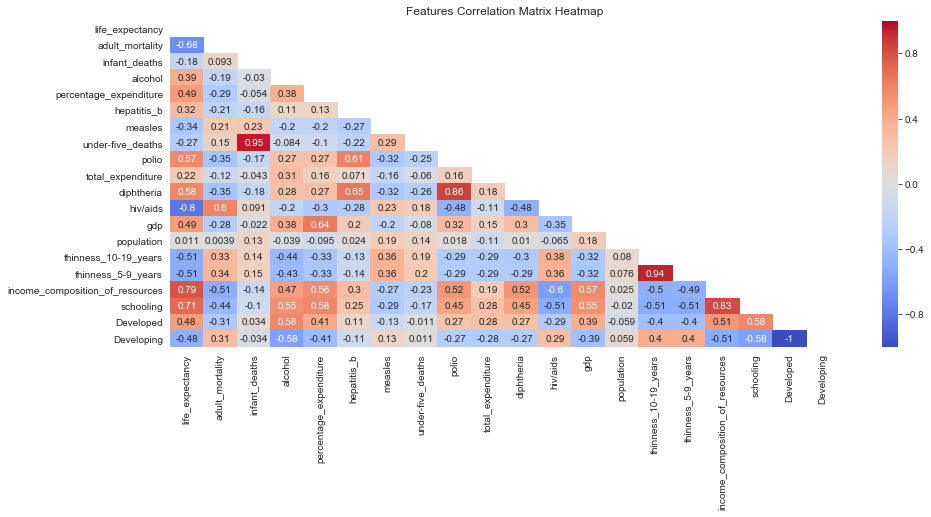

In [58]:
def feat_heatmap():
    mask = np.triu(feat_df.corr())
    plt.figure(figsize=(15,6))
    sns.heatmap(feat_df.corr(), annot=True, fmt='.2g', vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=mask)
    plt.ylim(len(feat_df.columns), 0)
    plt.title('Features Correlation Matrix Heatmap')
    plt.show()
feat_heatmap()

We are only needing to keep the variables that are not extremely correlated with another variable here besides life expectancy, as they can only skew our data. The general rule of thumb is to remove anything with a +/- 70% correlation value. These were mentioned above, but to go through them again

Infant Deaths/Under Five Deaths - Keep the more highly correlated variable with life expectancy, which is Under Five Deaths

GDP/Percentage Expenditure - Keep GDP

Polio/Diphtheria - Keep Diphtheria

Thinness - Keep Thinness 5-9

Income/Schooling - Keep Income

Developed/Developing - Keep Developed

Also will drop population as it is not correlated whatsoever.

In [59]:
feat_df.drop(columns=['infant_deaths', 'percentage_expenditure', 'polio', 'thinness_10-19_years', 'schooling', 'Developing', 'population'], inplace=True)

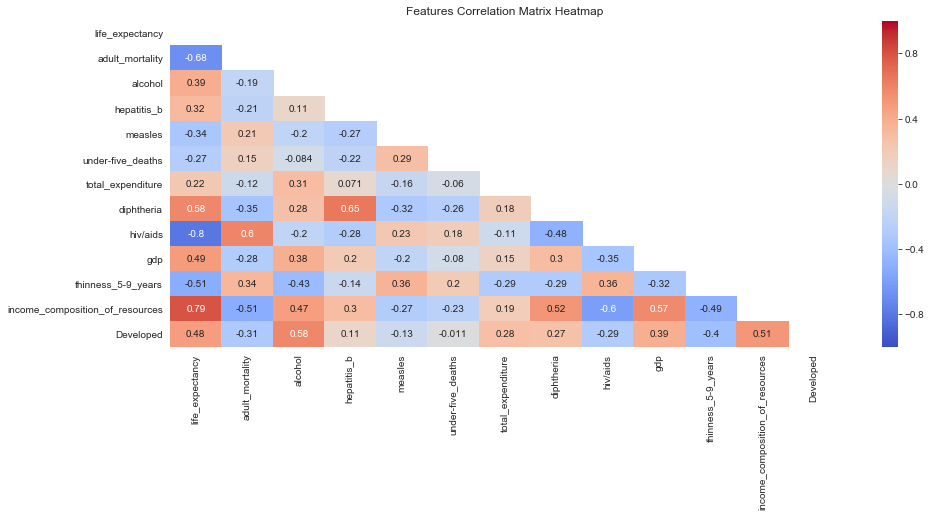

In [60]:
feat_heatmap()

So now that we have all moderately correlated values, we can use PCA to reduce the amount of dimensions we are looking at. The requirements must be met though. We need continuous data, a proper sample size, normalized data, correlation, linearity, and no outliers.

So far we have sample size, outliers, and correlation down, but we have to make sure all other requirements are met.

In [61]:
pca_df = feat_df.drop(columns='Developed').copy()

In [62]:
pca_df.drop(columns='life_expectancy', inplace=True) 
#We don't need this variable to calculate the PCA
len(pca_df.columns)

11

In [65]:
X = scale(pca_df)
sklearn_pca = PCA()
Y = sklearn_pca.fit_transform(X)
print('Explained Variance Ratio: ',sklearn_pca.explained_variance_ratio_)
print('Eigenvalues: ',sklearn_pca.explained_variance_)

Explained Variance Ratio:  [0.36440678 0.12120718 0.10346661 0.0859202  0.07462694 0.06377587
 0.05361359 0.04429972 0.037186   0.02712449 0.0243726 ]
Eigenvalues:  [4.00983943 1.33373298 1.13852026 0.94544399 0.8211758  0.70177346
 0.58995034 0.48746287 0.40918531 0.29847103 0.26818984]


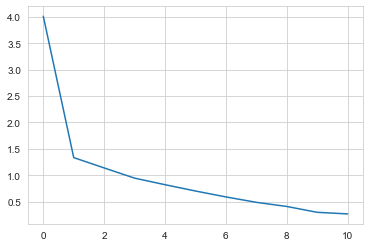

Explained Variance Ratio for First Component:  36.44067829700913%


In [77]:
plt.plot(sklearn_pca.explained_variance_)
plt.show()
print('Explained Variance Ratio for First Component: ', str(sklearn_pca.explained_variance_ratio_[0]*100)+'%')

With the variance we have, it would take almost all of our components to capture most of the variance. If we were to only keep the first component, we would only capture 36% of our variance, which is extremely low.

The best way to approach the model for this particular data would be to use the features listed before we started the PCA calculation.

1. Adult Mortality
2. Alcohol
3. Hepatitis B
4. Measles
5. Under-Five Deaths
6. Total Expenditure
7. Diphtheria
8. HIV/AIDS
9. GDP
10. Thinness 5-9 Years Old
11. Income Composition of Resources
12. Developed

All of these variables have good to great correlation with Life Expectancy without correlating with one another too greatly. If we remove more variables than this, our data becomes too narrow and does not cover enough variance that is involved with the dataset. These 12 variables will prove to be enough for further modeling and it is not overwhelming.

# Conclusion

Ultimately, we started the dataset with 21 variables we had to clean and explore and ended up with 12 different features to compare and correlate with our focus, Life Expectancy. Better analyses can be done to further bring down these features, but this is a starting point for any future models.

In accordance with general EDA technique, the data was first cleaned and missing values and outliers were dealt with. Missing values were interpolated until there were no missing or null values. But when interpolation was attempted on the values missing when we arranged the data by time, it proved insignificant. Instead those values were imputed with the means of every country by year. Using the winsorization, we cut down the data variable by variable using visual analysis on boxplots until there were no outliers remaining.

The data was analyzed and made sure to be continuous for each variable. Then we use the Status of each country due to the binary state of the variable. There might be much better analyses to be done on other variables, but the simplicity of this variable plus it's significance makes it perfect to work with. We then use this variable to correlate with life expectancy as well as other variables. The correlation matrix and heatmap was then used to see which values were highly correlated with what. There was definitely significance after running some tests so we moved on to create new variables for the dataset 'Developed' and 'Developing' and focused on that when we started engineering our features.



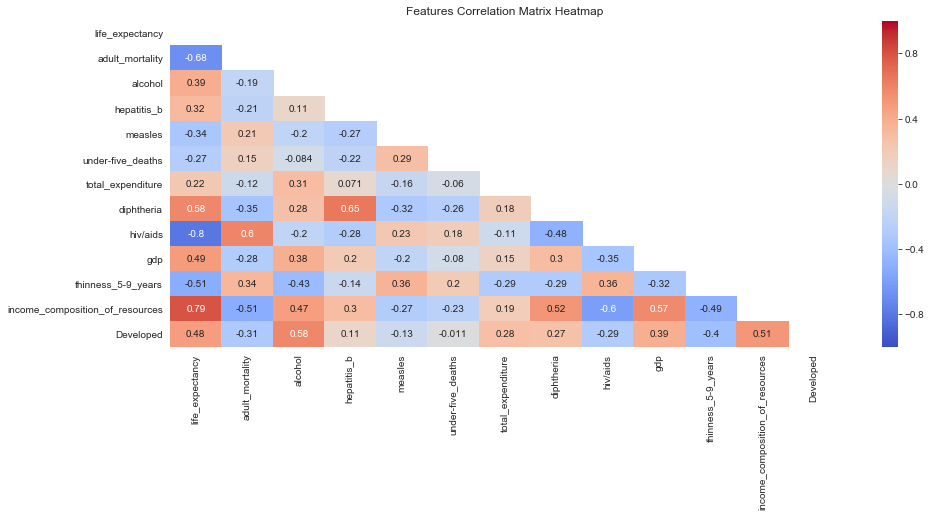

In [78]:
feat_heatmap()

Then, we cleaned up the data even further to remove variables that had no effect on our current focus, which was 'Status' and 'Life Expectancy'. Then we again ran a correlation matrix and identified any variables that had too high a correlation with other variables that weren't our target variable, as it would be repetitive. We reduced our variables from 20 to 12 using this method. Then we attempted to use PCA to further bring down the amoutn of features, though it was not successful. So the most efficient amount of features came down to 12 from the analysis done here. The features presented are the most representative of our target 'Life Expectancy'. Please refer to the heatmap above to see the target variable and the features selected for this model. Thank you.